In [1]:
"""
@file four_class_classification.ipynb
@author Ryan Missel

This notebook handles testing a simple classification case where 4 Gaussian distribution clusters
are plotted near each other and the network is tasked with classifying them. The idea is to check
the decision boundaries outside of the training data for their classification and checking the
organization of the MetaPrior meta-space.

This will be extended to adding local codes for each data point and check how the drawn latent codes
are organized per class.
"""
import time
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as func
from tqdm.notebook import tqdm

from IPython.display import clear_output
import matplotlib.pyplot as plt

from scipy.stats import entropy
from metaprior.metautils import get_act, plot_metaspace_mean, plot_metaspace_var, plot_weight_correlations
from torch.distributions import Normal, kl_divergence as kl

In [2]:
class MetaPrior(nn.Module):
    def __init__(self, layer_sizes=[1, 100, 1], mean=False, local=False, activation='linear', hyperprior_dim=32, code_dim=2):
        super(MetaPrior, self).__init__()
        self.input_dim = layer_sizes[0]
        self.layer_sizes = layer_sizes
        self.code_dim = code_dim

        self.local = local
        self.mean = mean

        self.acts = [get_act('leaky_relu') if i < len(layer_sizes) - 2 else get_act(activation)
                         for i in range(len(layer_sizes) - 1)]

        self.embedder = nn.Sequential(
            nn.Linear(self.input_dim, 20),
            nn.LeakyReLU(),
            nn.Linear(20, code_dim)
        )

        # Define the initial weight code distribution parameters
        self.code_mu = nn.ParameterList([
            torch.nn.Parameter(
                torch.zeros([lsize, code_dim]) + 0.1 * torch.randn([lsize, code_dim], requires_grad=True),
                requires_grad=True)
            for lsize in self.layer_sizes
        ])

        self.code_var = nn.ParameterList([
            torch.nn.Parameter(torch.ones([lsize, code_dim]), # + 0.1 * torch.randn([lsize, code_dim], requires_grad=True),
                               requires_grad=False)
            for lsize in self.layer_sizes
        ])

        self.codes = [
            torch.randn([lsize, code_dim]) for lsize in self.layer_sizes
        ]


        # Define the hyperprior network that generates the distribution parameters of the Weights
        self.hyperprior = nn.Sequential(
            nn.Linear(code_dim * 2, 64),
            nn.LeakyReLU(),
            nn.Linear(64, hyperprior_dim)
        )

        self.mean_net = nn.Linear(hyperprior_dim, 1)
        self.var_net = nn.Linear(hyperprior_dim, 1)

    def generate_weight_codes(self):
        """
        Handles building the weight codes and draw samples from i
        :return:
        """
        # Sample the codes array
        self.codes = [
            self.code_mu[i] + torch.randn_like(self.code_mu[i]) * self.code_var[i]
            for i in range(len(self.layer_sizes))
        ]

        self.weight_codes = []
        self.bias_codes = []

        # Loop between the layers and generate their weight codes by concatenating each units' latent var.
        # Units in the smaller layer need to be duplicated to the size of the next layer in order to perform
        # easy concatenation between their latent variables
        for idx in range(len(self.layer_sizes) - 1):
            temp = self.codes[idx].unsqueeze(1).repeat(1, self.layer_sizes[idx + 1], 1).view([-1, self.code_dim])
            temp2 = self.codes[idx + 1].unsqueeze(0).repeat(self.layer_sizes[idx], 1, 1).view([-1, self.code_dim])
            concated = torch.cat((temp2, temp), dim=1)

            self.weight_codes.append(concated)

            # Generate bias codes (concatenation is just with a zeros vector)
            self.bias_codes.append(torch.cat((self.codes[idx + 1], torch.zeros_like(self.codes[idx + 1])), dim=1))

    def kl_z_term(self):
        """
        KL term related to the distribution parameters of the meta-variables, with prior N(0, 1)
        :return: Sum of the KL values over each latent variable
        """
        mus = torch.cat([cmu.view([-1]) for cmu in self.code_mu])
        var = torch.cat([cvar.view([-1]) for cvar in self.code_var])

        q = Normal(mus, var)
        N = Normal(torch.zeros(len(mus), device=mus.device), torch.ones(len(mus), device=mus.device))
        klz = kl(q, N).sum()
        return klz

    def forward(self, x, perturb=False):
        """
        Handles iterating through each layer, generating the distribution parameters and sampling
        the weights and biases for that layer
        :param x: input x
        :param perturb: whether to perturb one meta-var
        """
        # Generate weight codes given current latent codes
        self.generate_weight_codes()
        local_code = self.embedder(x)

        # Perturb one meta-var to test function draws
        if perturb:
            indice = np.random.randint(0, self.weight_codes[0].shape[0], 1)
            self.weight_codes[0][indice] += torch.hstack((torch.zeros([2]), 2 * torch.randn([2])))

        # Iterate over layers to get output
        for lidx in range(len(self.layer_sizes) - 1):
            # Get latent codes of hyperprior
            if self.local:
                latent_w = self.hyperprior(torch.cat((self.weight_codes[lidx], local_code), dim=1))
                latent_b = self.hyperprior(torch.cat((self.bias_codes[lidx], local_code), dim=1))
            else:
                latent_w = self.hyperprior(self.weight_codes[lidx])
                latent_b = self.hyperprior(self.bias_codes[lidx])

            # Sample weights
            w_mu, w_var = self.mean_net(latent_w), self.var_net(latent_w)
            w = (w_mu + torch.randn_like(w_mu) * w_var).view([self.layer_sizes[lidx], self.layer_sizes[lidx + 1]])

            # Sample biases
            b_mu, b_var = self.mean_net(latent_b), self.var_net(latent_b)
            b = (b_mu + torch.randn_like(b_mu) * b_var).squeeze()

            # Perform the linear layer and activate
            x = func.linear(x, w.T, b)
            x = self.acts[lidx](x)
            
        return x

    def bce_predict(self, x):
        """ Simply turns the softmax outputs into full class predictions """
        # Apply softmax to output.
        pred = self.forward(x)

        ans = []
        # Pick the class with maximum weight
        for t in pred:
            if t < 0.5:
                ans.append(0)
            else:
                ans.append(1)
        return ans

    def ce_predict(self, x):
        """ Get class predictions from prediction vector """
        pred = self.forward(x).detach().cpu().numpy()
        argmax = np.argmax(pred, axis=1)
        return argmax

    def weight_correlations(self, x, indice, layer, shift):
        """ Get the weight vectors of two random nodes to another """
        # Clamp the weight code to its distribution mean
        # self.codes = [self.code_mu[i] for i in range(len(self.layer_sizes))]
        self.codes = [
            self.code_mu[i] + torch.randn_like(self.code_mu[i]) * self.code_var[i]
            for i in range(len(self.layer_sizes))
        ]

        self.codes[layer + 1][indice] = self.code_mu[layer + 1][indice] + torch.Tensor(shift)

        # Generate weight codes
        self.weight_codes = []
        self.bias_codes = []

        # Loop between the layers and generate their weight codes by concatenating each units' latent var.
        # Units in the smaller layer need to be duplicated to the size of the next layer in order to perform
        # easy concatenation between their latent variables
        for idx in range(len(self.layer_sizes) - 1):
            temp = self.codes[idx].unsqueeze(1).repeat(1, self.layer_sizes[idx + 1], 1).view([-1, self.code_dim])
            temp2 = self.codes[idx + 1].unsqueeze(0).repeat(self.layer_sizes[idx], 1, 1).view([-1, self.code_dim])
            concated = torch.cat((temp, temp2), dim=1)

            self.weight_codes.append(concated)

            # Generate bias codes (concatenation is just with a zeros vector)
            self.bias_codes.append(torch.cat((self.codes[idx + 1], torch.zeros_like(self.codes[idx + 1])), dim=1))

        # Iterate over layers to get output
        w_out = None
        for lidx in range(len(self.layer_sizes) - 1):
            # Get latent codes of hyperprior
            latent_w = self.hyperprior(self.weight_codes[lidx])
            latent_b = self.hyperprior(self.bias_codes[lidx])

            # Sample weights
            w_mu, w_var = self.mean_net(latent_w), self.var_net(latent_w)
            w = (w_mu + torch.randn_like(w_mu) * w_var.exp()).view([self.layer_sizes[lidx], self.layer_sizes[lidx + 1]])

            # Get the sampled weight for the specific layer
            if lidx == layer:
                w_out = w

            # Sample biases
            b_mu, b_var = self.mean_net(latent_b), self.var_net(latent_b)
            b = (b_mu + torch.randn_like(b_mu) * b_var.exp()).squeeze()

            # Perform the linear layer and activate
            x = func.linear(x, w.T, b)
            print(self.acts[lidx])
            x = self.acts[lidx](x)

        # Return only the node weights that are cared about
        return x, w_out[:, indice]

In [3]:
def plot_decision_boundary(pred_func, X, y):
    """
    Handles plotting a decision boundary around the data-space by sampling the class prediction of the
    network over a grid
    """
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 5, X[:, 0].max() + 5
    y_min, y_max = X[:, 1].min() - 5, X[:, 1].max() + 5
    h = 0.01

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict the function value for the whole gid
    E, Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    E = entropy(E, axis=1).reshape(xx.shape)
    Z = Z.reshape(xx.shape)

    # Plot the contour and training examples
    figure, axis = plt.subplots(1, 2)

    axis[0].contourf(xx, yy, E, cmap='Blues')
    axis[0].set_title("Entropy Plot")
    axis[0].scatter(X[:, 0], X[:, 1], c=y)

    axis[1].contourf(xx, yy, Z, cmap='cividis')
    axis[1].set_title("Prediction Plot")
    axis[1].scatter(X[:, 0], X[:, 1], c=y)

    plt.show()


def predict(x):
    """ Simply probes the network for its prediction given a data point, x """
    # Convert into numpy element to tensor
    x = torch.from_numpy(x).type(torch.FloatTensor)
    # Predict and return ans
    ent = func.softmax(net(x), dim=1)
    ans = torch.argmax(ent, dim=1).int()
    return ent.detach().numpy(), ans.detach().numpy()

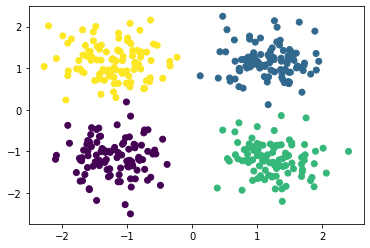

In [4]:
def gauss_sample(xmean, xsig, ymean, ysig, n, classnum):
    xsamp = np.random.normal(xmean, xsig, [n, 1])
    ysamp = np.random.normal(ymean, ysig, [n, 1])
    return np.hstack((xsamp, ysamp)), np.full([n], fill_value=classnum)

# Create dataset from sampling the gaussians
x1, y1 = gauss_sample(-1.2, 0.4, -1.2, 0.4, 100, 0)
x2, y2 = gauss_sample(1.2, 0.4, 1.2, 0.4, 100, 1)
x3, y3 = gauss_sample(1.2, 0.4, -1.2, 0.4, 100, 2)
x4, y4 = gauss_sample(-1.2, 0.4, 1.2, 0.4, 100, 3)

X = np.vstack((x1, x2, x3, x4))
y = np.concatenate((y1, y2, y3, y4))

p = np.random.permutation(X.shape[0])
X, y = X[p], y[p]

X = torch.from_numpy(X).type(torch.FloatTensor)
y = torch.from_numpy(y).type(torch.LongTensor)
# y_hot = func.one_hot(y, 4).type(torch.LongTensor)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.show()

In [5]:
# Define network
net = MetaPrior([2, 50, 4], mean=False, local=False, hyperprior_dim=32, code_dim=4, activation='logsoftmax')
optim = torch.optim.Adam(net.parameters(), lr=0.01)
sched = torch.optim.lr_scheduler.StepLR(optim, step_size=5000, gamma=0.75)
ce = nn.CrossEntropyLoss()

nll = nn.NLLLoss()

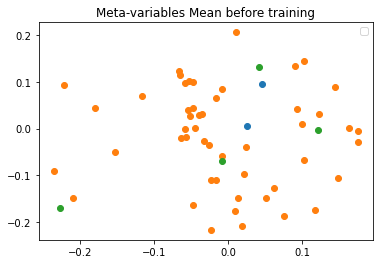

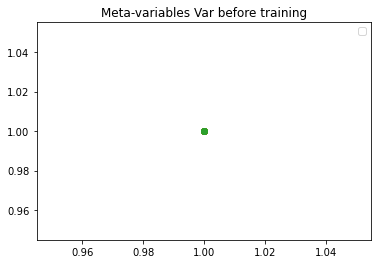

In [6]:
# Plot metaspace mean/var
plot_metaspace_mean(net, train=True)
plot_metaspace_var(net, train=True)
# plot_weight_correlations(net, X, 12, 0)

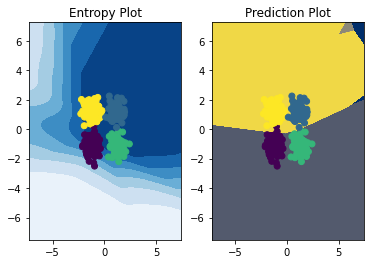

Ep 0: CE 1.58264 KLZ 1.14903 Acc 0.2875


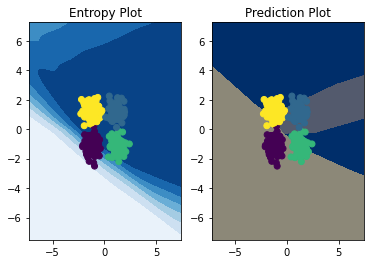

Ep 1000: CE 0.68006 KLZ 18.82557 Acc 0.7275


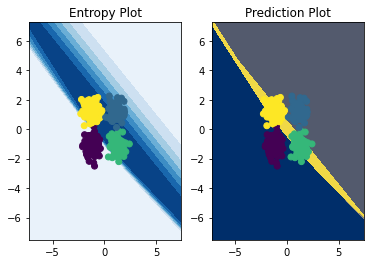

Ep 2000: CE 0.42614 KLZ 20.69608 Acc 0.7275


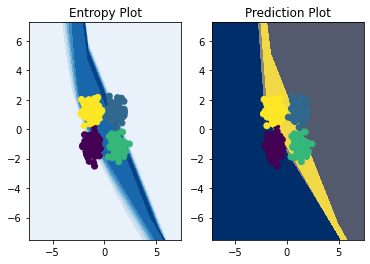

Ep 3000: CE 0.48861 KLZ 28.36535 Acc 0.72


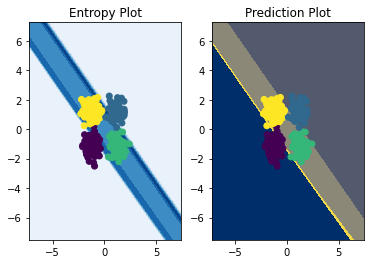

Ep 4000: CE 0.42259 KLZ 26.74602 Acc 0.7325


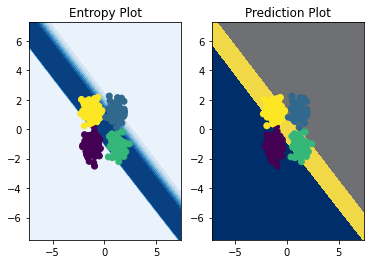

Ep 5000: CE 0.43927 KLZ 29.45465 Acc 0.715


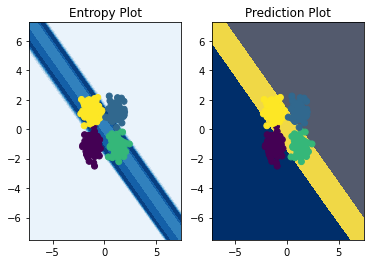

Ep 6000: CE 0.53090 KLZ 30.00310 Acc 0.73


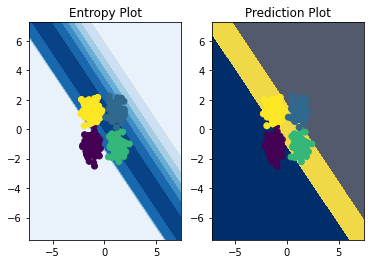

Ep 7000: CE 0.60540 KLZ 31.10195 Acc 0.7125


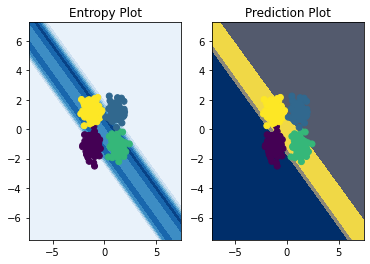

Ep 8000: CE 0.48698 KLZ 30.18878 Acc 0.73


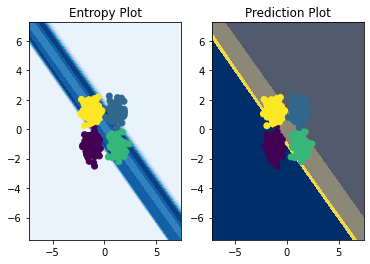

Ep 9000: CE 0.44497 KLZ 29.51115 Acc 0.7175


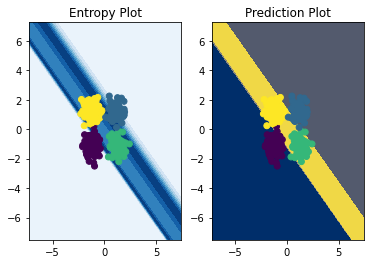

Ep 10000: CE 0.68880 KLZ 31.62105 Acc 0.72


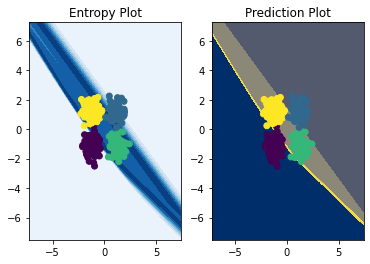

Ep 11000: CE 0.47335 KLZ 30.04415 Acc 0.7075


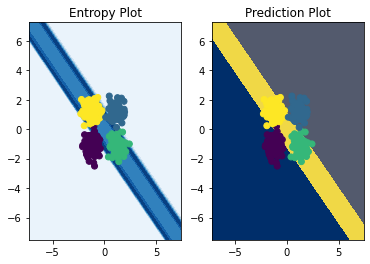

Ep 12000: CE 0.38991 KLZ 27.89734 Acc 0.72


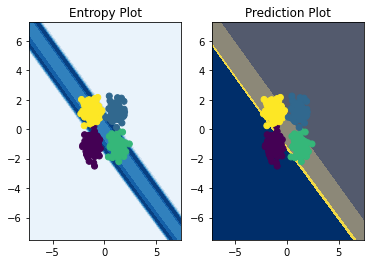

Ep 13000: CE 0.37371 KLZ 27.30912 Acc 0.7275


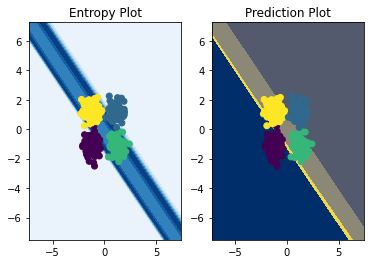

Ep 14000: CE 0.53492 KLZ 28.89791 Acc 0.7225


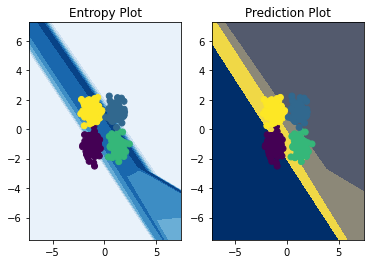

Ep 15000: CE 0.49307 KLZ 27.75592 Acc 0.725


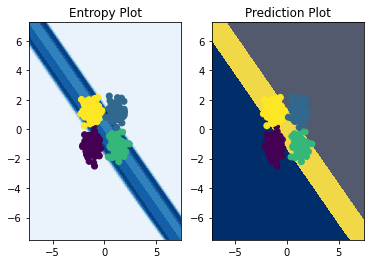

Ep 16000: CE 0.46677 KLZ 28.30195 Acc 0.715


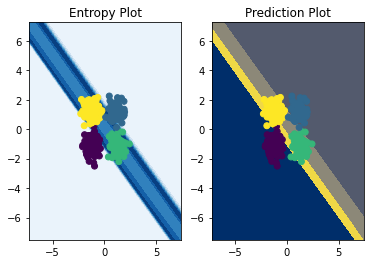

Ep 17000: CE 0.64984 KLZ 27.93823 Acc 0.715


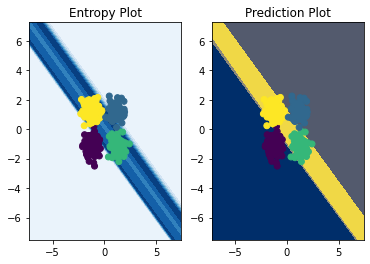

Ep 18000: CE 0.40061 KLZ 27.52114 Acc 0.7275


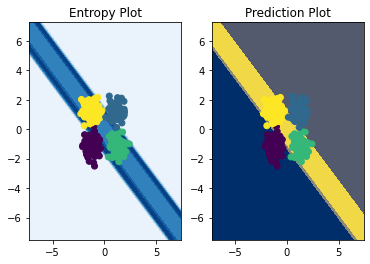

Ep 19000: CE 0.46697 KLZ 26.45389 Acc 0.7325


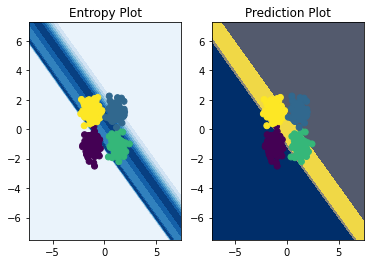

Ep 20000: CE 0.49678 KLZ 26.36465 Acc 0.7225


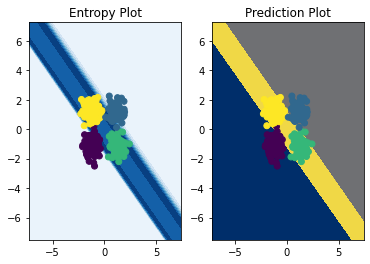

Ep 21000: CE 0.55121 KLZ 26.06628 Acc 0.7475


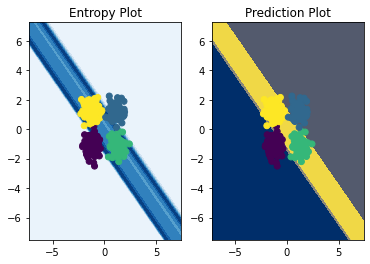

Ep 22000: CE 0.47765 KLZ 26.78850 Acc 0.72


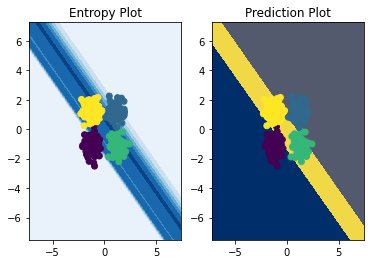

Ep 23000: CE 0.54065 KLZ 25.48386 Acc 0.7075


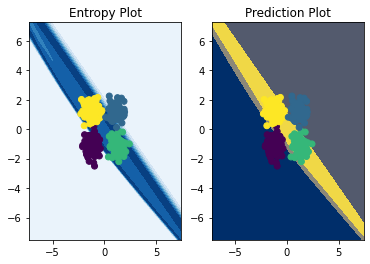

Ep 24000: CE 0.53848 KLZ 26.11740 Acc 0.7175


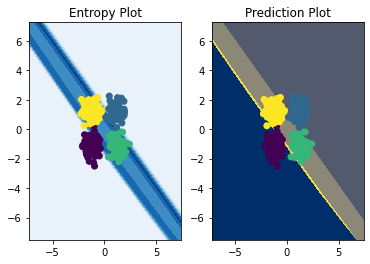

Ep 25000: CE 0.40763 KLZ 27.07765 Acc 0.72


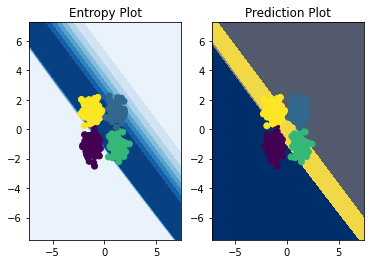

Ep 26000: CE 0.38773 KLZ 26.55332 Acc 0.7325


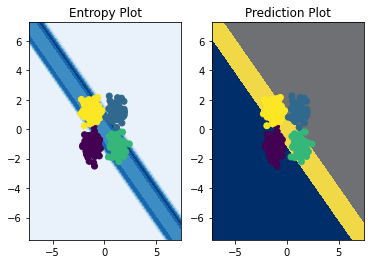

Ep 27000: CE 0.37972 KLZ 26.73589 Acc 0.7325


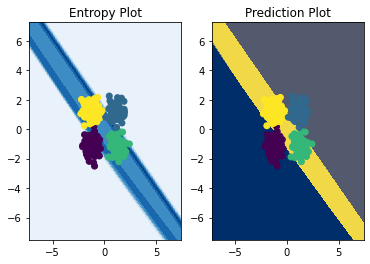

Ep 28000: CE 0.51103 KLZ 26.89891 Acc 0.7125


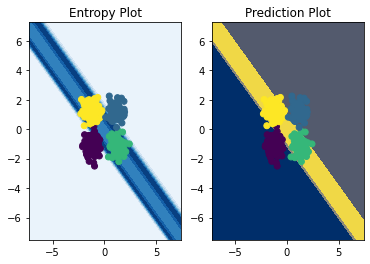

Ep 29000: CE 0.41473 KLZ 26.86362 Acc 0.72


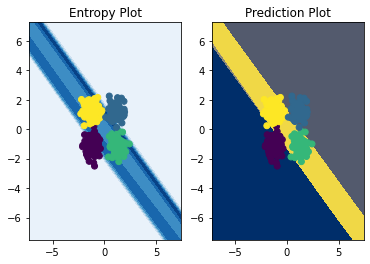

Ep 30000: CE 0.65801 KLZ 26.66421 Acc 0.7225


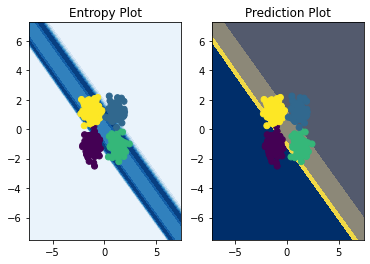

Ep 31000: CE 0.43014 KLZ 26.10912 Acc 0.73


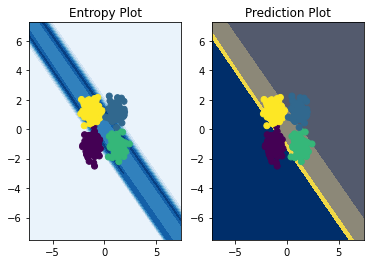

Ep 32000: CE 0.48421 KLZ 26.66282 Acc 0.7325


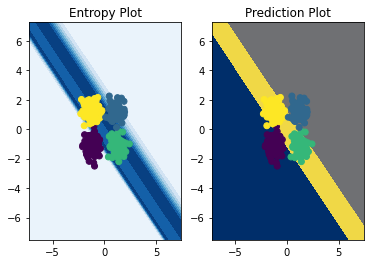

Ep 33000: CE 0.48931 KLZ 26.43232 Acc 0.73


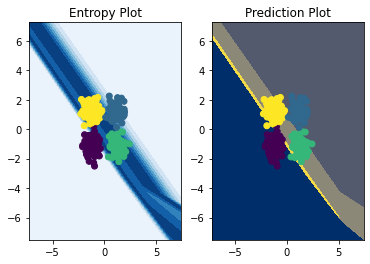

Ep 34000: CE 0.46746 KLZ 26.11421 Acc 0.72


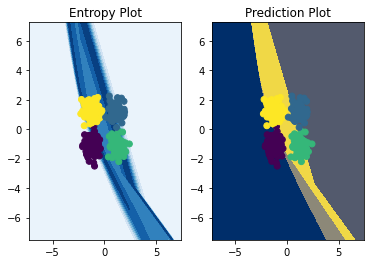

Ep 35000: CE 0.50360 KLZ 25.58056 Acc 0.735


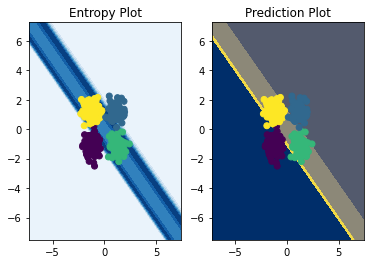

Ep 36000: CE 0.48327 KLZ 25.02293 Acc 0.73


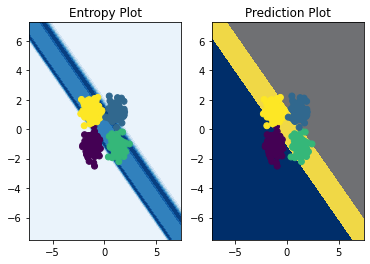

Ep 37000: CE 0.56687 KLZ 25.53237 Acc 0.72


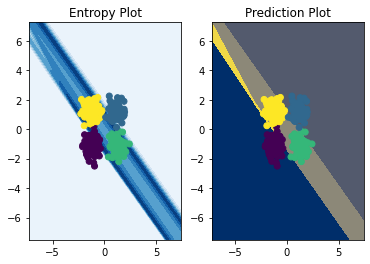

Ep 38000: CE 0.39368 KLZ 25.53188 Acc 0.745


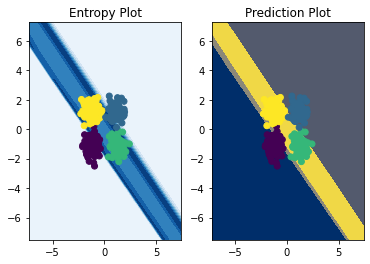

Ep 39000: CE 0.41890 KLZ 25.07804 Acc 0.7275


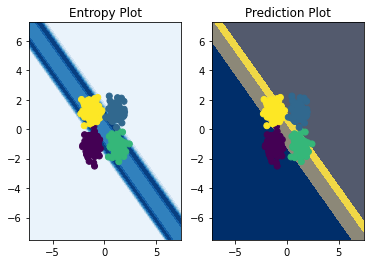

Ep 40000: CE 0.42218 KLZ 25.13489 Acc 0.72


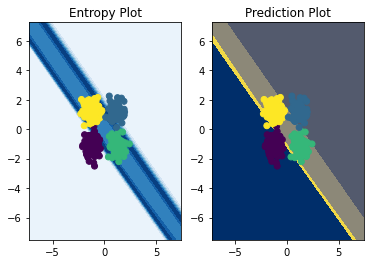

Ep 41000: CE 0.51066 KLZ 25.06670 Acc 0.725


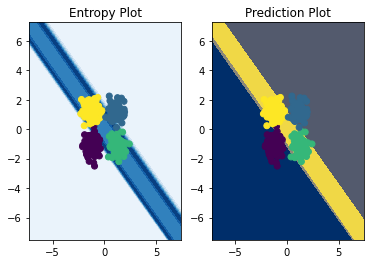

Ep 42000: CE 0.47561 KLZ 25.15367 Acc 0.7325


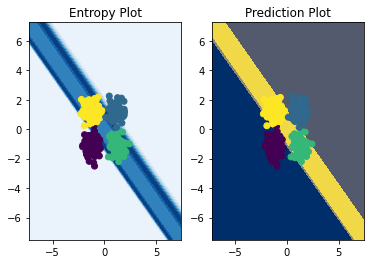

Ep 43000: CE 0.39091 KLZ 24.69240 Acc 0.72


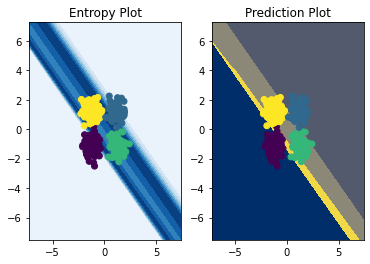

Ep 44000: CE 0.56968 KLZ 24.50233 Acc 0.73


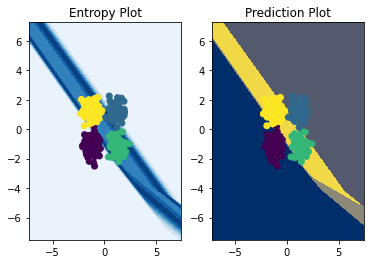

Ep 45000: CE 0.45301 KLZ 25.17269 Acc 0.73


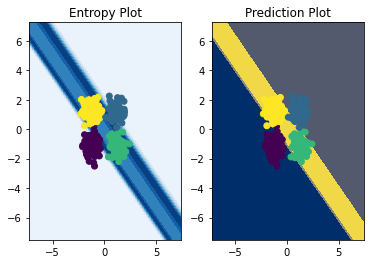

Ep 46000: CE 0.41733 KLZ 24.82148 Acc 0.7275


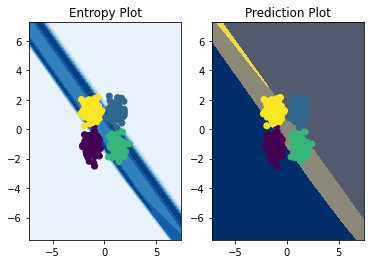

Ep 47000: CE 0.44672 KLZ 24.55037 Acc 0.6775


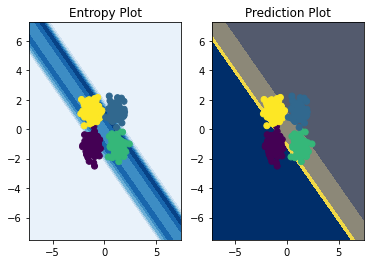

Ep 48000: CE 0.50706 KLZ 24.54255 Acc 0.7375


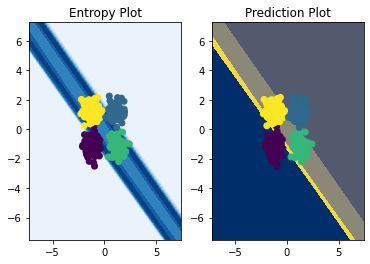

Ep 49000: CE 0.39180 KLZ 24.38290 Acc 0.7175


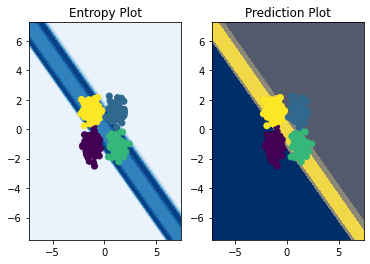

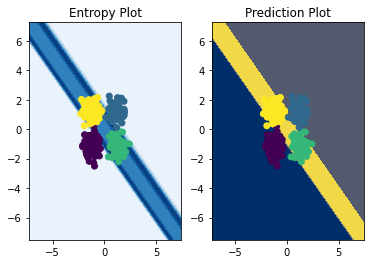

In [7]:
plot_decision_boundary(lambda x: predict(x), X, y)
for ep in tqdm(range(50000)):
    optim.zero_grad()


#     clear_output()
    # Sub-sample
    indices = torch.randperm(len(X))[:50]
    x_batch, y_batch = X[indices], y[indices]

    celoss = 0
    for _ in range(5):
        preds = net(x_batch)

        cel = nll(preds, y_batch)
        celoss += cel

    celoss /= 5

    acc = sum(np.argmax(net(X).detach().cpu().numpy(), axis=1) == y.numpy()) / y.shape[0]

    klz = net.kl_z_term()
    loss = celoss + 0.005 * klz

    if ep % 1000 == 0:
        print("Ep {}: CE {:0.5f} KLZ {:0.5f} Acc {}".format(ep, celoss, klz, acc))
        plot_decision_boundary(lambda x: predict(x), X, y)
    
    loss.backward()
    optim.step()
    sched.step()
#     
#     # Plot metaspace mean/var
#     plot_metaspace_mean(net, train=True)
#     plot_metaspace_var(net, train=True)
# #     plot_weight_correlations(net, X, 50, 0)
#     time.sleep(1)
#     plot_decision_boundary(lambda x: predict(x), X, y)
#     time.sleep(1)

plot_decision_boundary(lambda x: predict(x), X, y)
